<a href="https://colab.research.google.com/github/yeansam/APTOS_Messidor-2/blob/master/APTOS_(FYP_2_best_solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define packages

In [ ]:
#standard libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
import cv2
from PIL import Image
from tqdm import tqdm

#machine learning packages
import tensorflow as tf
from keras import layers, Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Mount Google Drive and load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -a '/content/drive/My Drive/train_images_ben_preprocessed_sigmaX10' '/content/'

In [ ]:
!cp -a '/content/drive/My Drive/test_images_ben_preprocessed_sigmaX10' '/content/'

## Exploratory data analysis (EDA)

Load csv into data frames

In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv('/content/test.csv')
print(train_df.shape)
print(test_df.shape)

(3662, 2)
(1928, 1)


In [ ]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

0    1805
1     370
2     999
3     193
4     295
Name: diagnosis, dtype: int64

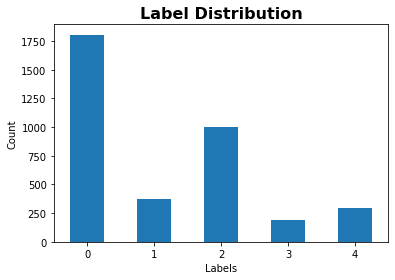

In [ ]:
train_df.diagnosis.value_counts().sort_index().plot(kind="bar", rot=0)
plt.title("Label Distribution", fontsize=16, weight='bold')
plt.xlabel("Labels")
plt.ylabel('Count')
plt.savefig('label_distribution.png')

train_df.diagnosis.value_counts().sort_index()

## Display image samples

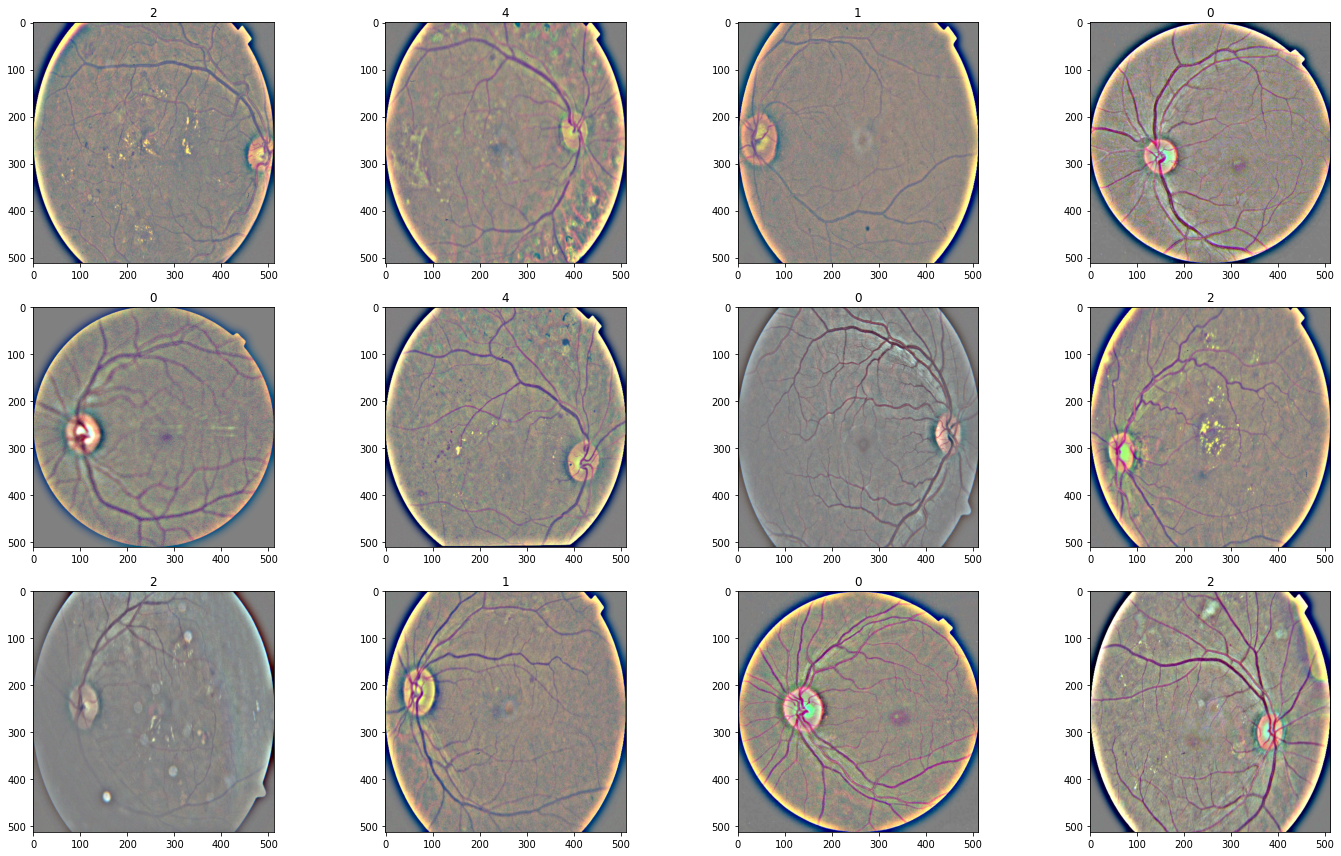

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/train_images_ben_preprocessed_sigmaX10/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

## Resizing (224x224)

In [ ]:
def resize_image(image_path, size=224):
    im = Image.open(image_path)
    im = im.resize((size, )*2)
    
    return im

## Load train and test datasets into arrays

In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(train_df['id_code']):
    x_train[i, :, :, :] = resize_image(f'/content/train_images_ben_preprocessed_sigmaX10/{image_id}.png')

In [ ]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = resize_image(f'/content/test_images_ben_preprocessed_sigmaX10/{image_id}.png')

100%|██████████| 1928/1928 [00:27<00:00, 69.05it/s]


In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [ ]:
print(y_train)

[[0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 ...
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


## Convert single-labels to multi-labels


In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
print(y_train_multi)

[[1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 0 0]
 ...
 [1 1 1 0 0]
 [1 0 0 0 0]
 [1 1 1 0 0]]


## Train/test data spliting for validation

In [ ]:
#split data to 85/15
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, random_state=42
)

## Loading network (Densenet121)

In [ ]:
#call in densenet without the top layer
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

29089792/29084464 [==============================] - 3s 0us/step


In [ ]:
#build a model with densenet layers
def model_build():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = model_build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


## Creating call-back metrics

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('/content/model.h5')

        return

## Data augmentation and setting batch size

In [ ]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        # # 1 (ori)
        # zoom_range=0.15,  # set range for random zoom
        # # set mode for filling points outside the input boundaries
        # fill_mode='constant',
        # cval=0.,  # value used for fill_mode = "constant"
        # horizontal_flip=True,  # randomly flip images
        # vertical_flip=True,  # randomly flip images

        # # 2 (https://towardsdatascience.com/blindness-detection-diabetic-retinopathy-using-deep-learning-on-eye-retina-images-baf20fcf409e) (down)
        # # rescale=1./224,
        # rotation_range=360,
        # brightness_range=[0.5, 1.5],
        # zoom_range=[1, 1.2],
        # zca_whitening=True,
        # horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode='constant'

        # # 3 (https://towardsdatascience.com/blindness-detection-diabetic-retinopathy-using-deep-learning-on-eye-retina-images-baf20fcf409e) (up)
        # featurewise_center=True,
        # featurewise_std_normalization=True,
        # rotation_range=20,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # horizontal_flip=True

        # # 4 (https://medium.com/@jdmitchell0216/diabetic-retinopathy-ml-diagnosis-basic-preprocessing-and-augmentation-with-keras-167b9f7396b5)
        # # rescale=1./255,
        # featurewise_center=True,
        # horizontal_flip=True,
        # # validation_split=0.2,
        # fill_mode="nearest",
        # zoom_range=0.1,
        # rotation_range=45

        # 5 (https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108185)
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
        # preprocessing_function=preprocess_image, 
        # rescale=1 / 255.

    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=42)

## Display transformed images

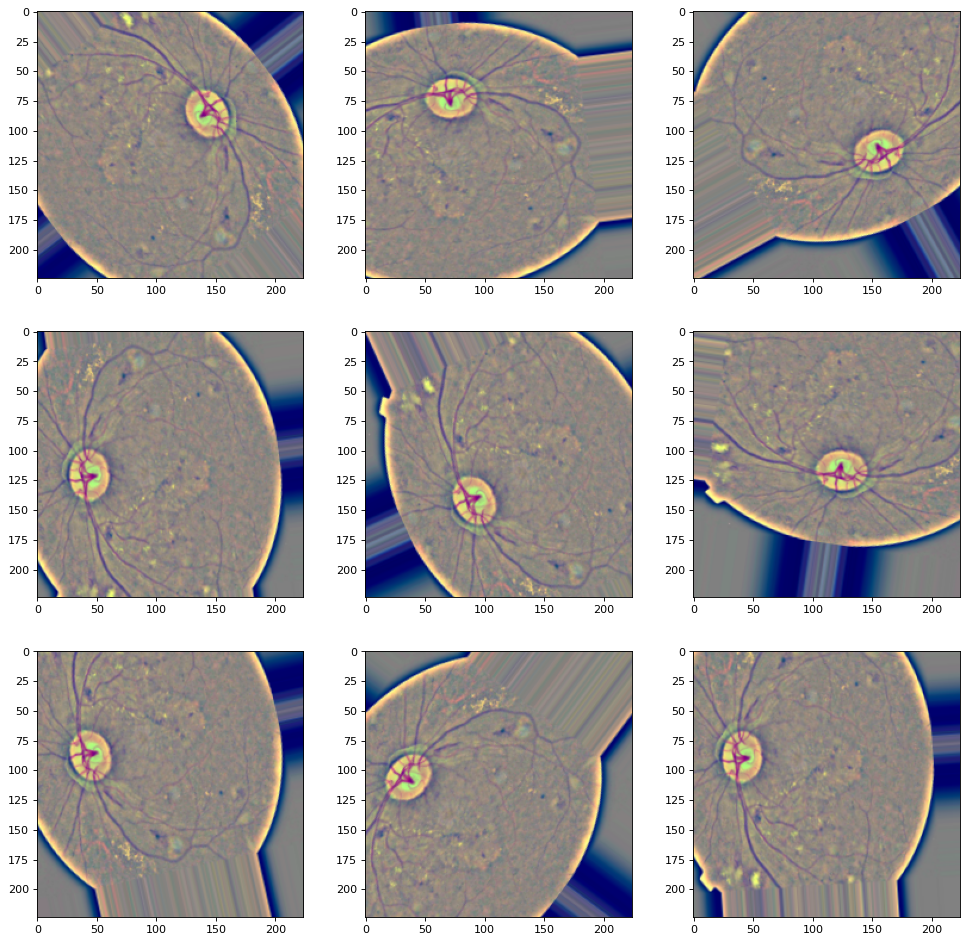

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')

for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = data_generator[1]
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image[0])
# show the figure
pyplot.show()


## Training the model and Evaluation

In [ ]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=150,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/150
98/97 [==============================] - 220s 2s/step - loss: 0.4286 - accuracy: 0.7939 - val_loss: 0.3125 - val_accuracy: 0.8800
val_kappa: 0.6533
Validation Kappa has improved. Saving model.
Epoch 2/150
98/97 [==============================] - 156s 2s/step - loss: 0.2177 - accuracy: 0.9180 - val_loss: 0.1839 - val_accuracy: 0.9302
val_kappa: 0.8236
Validation Kappa has improved. Saving model.
Epoch 3/150
98/97 [==============================] - 155s 2s/step - loss: 0.1723 - accuracy: 0.9332 - val_loss: 0.1576 - val_accuracy: 0.9349
val_kappa: 0.8607
Validation Kappa has improved. Saving model.
Epoch 4/150
98/97 [==============================] - 155s 2s/step - loss: 0.1501 - accuracy: 0.9420 - val_loss: 0.1503 - val_accuracy: 0.9400
val_kappa: 0.8606
Epoch 5/150
98/97 [==============================] - 155s 2s/step - loss: 0.1399 - accuracy: 0.9440 - val_loss: 0.1230 - val_accuracy: 0.9538
val_kappa: 0.9003
Validation Kappa has improved. Saving model.
Epoch 6/150
98/97 [=

Text(0, 0.5, '% Accuracy')

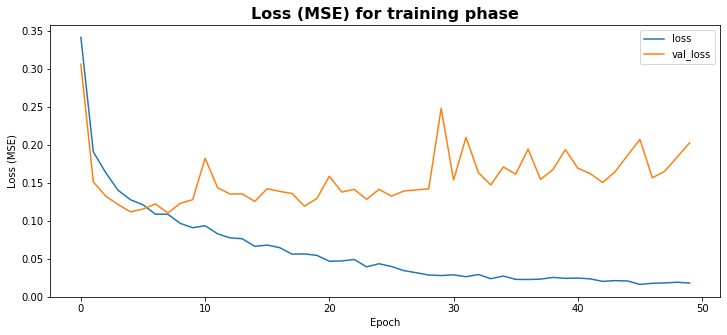

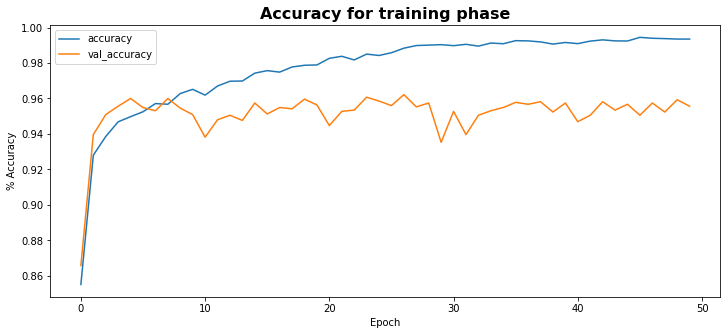

In [ ]:
with open('/content/history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE) for training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy for training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

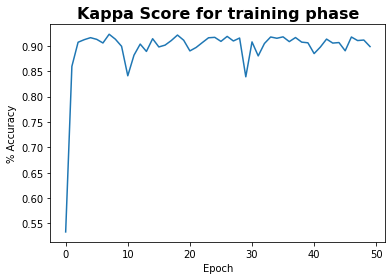

In [ ]:
plt.plot(kappa_metrics.val_kappas)
plt.title("Kappa Score for training phase", fontsize=16,weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")
plt.savefig("kappa_score.png")

## Prediction on test dataset

In [ ]:
model.load_weights('/content/model.h5')
# y_val_pred = model.predict(x_val)

In [ ]:
array_pred = model.predict(x_test)
print(array_pred)

[[9.9996555e-01 9.9943572e-01 6.4254487e-01 7.8139146e-04 9.2672516e-04]
 [9.9964726e-01 9.9949074e-01 9.9786466e-01 3.2440874e-01 6.1208429e-03]
 [9.9998653e-01 9.9993217e-01 9.9964428e-01 5.9030924e-02 4.6882877e-04]
 ...
 [9.9993479e-01 9.9979287e-01 9.9808323e-01 1.1906152e-01 3.7335383e-04]
 [9.9995577e-01 9.9901807e-01 9.9983120e-01 9.8869437e-01 6.0894567e-01]
 [9.9988866e-01 9.8214620e-01 3.6050927e-02 8.2171122e-03 1.0737385e-02]]


In [ ]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('result.csv',index=False)

## Prediction evaluation

In [ ]:
y_test_bar = model.predict(x_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0005cfc8afb6


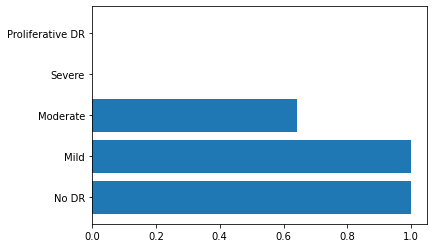

003f0afdcd15


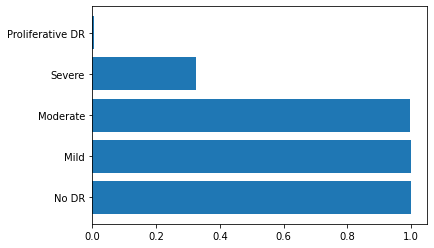

006efc72b638


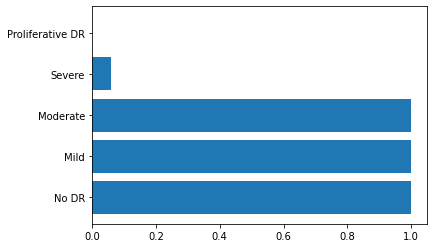

00836aaacf06


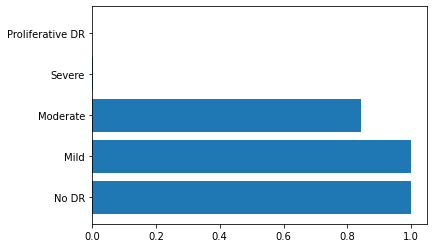

009245722fa4


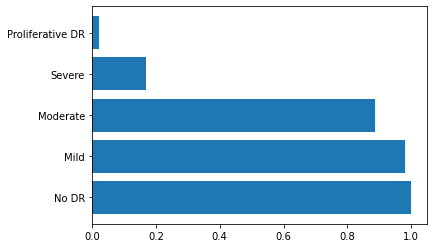

009c019a7309


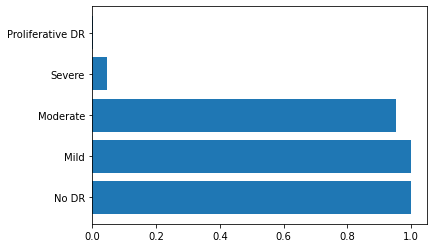

010d915e229a


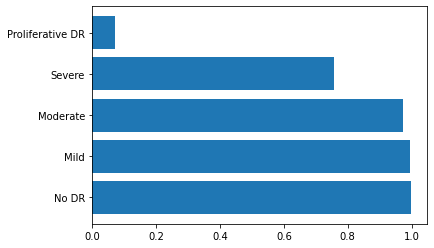

0111b949947e


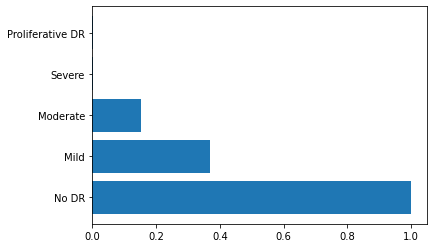

01499815e469


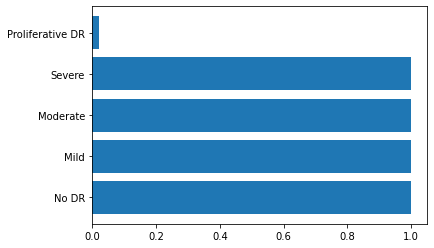

0167076e7089


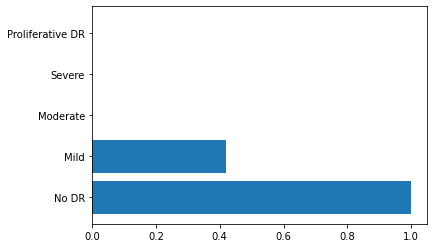

01c31b10ab99


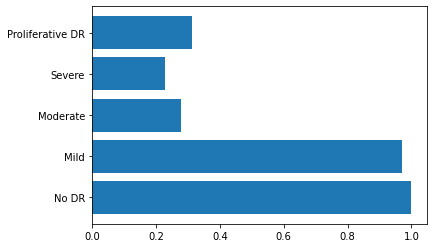

01c5ba195207


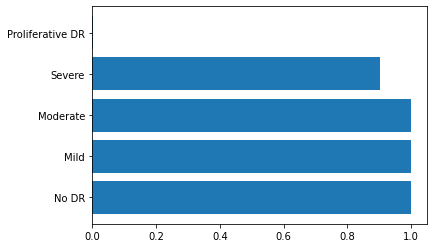

01e4d86b3a30


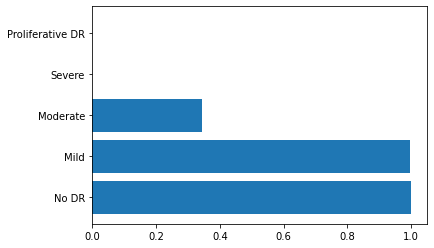

020921b796d5


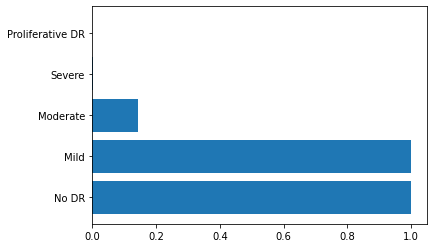

020f6983114d


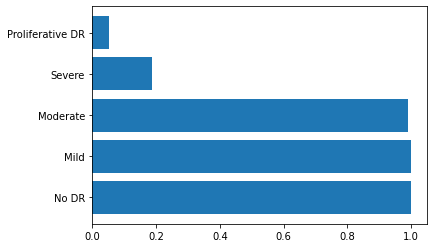

021c207614d6


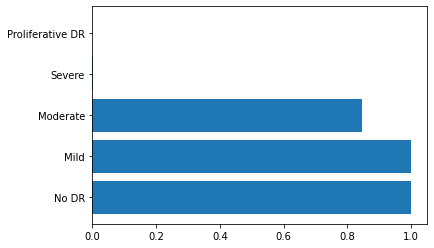

0229c0a80d42


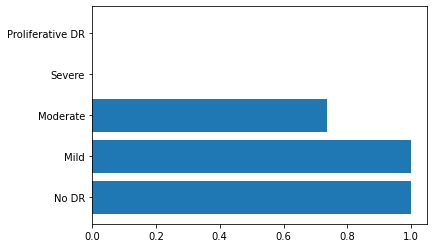

024d0a225db1


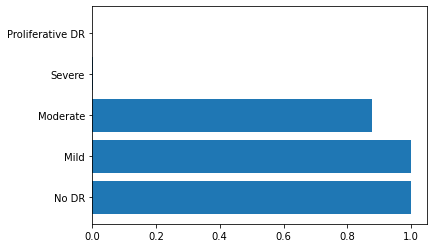

0268f4382c67


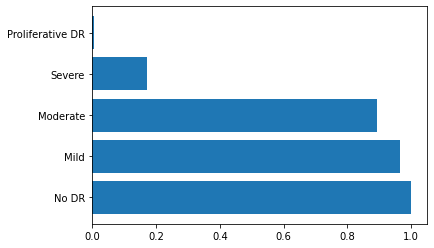

0299d97f31f7


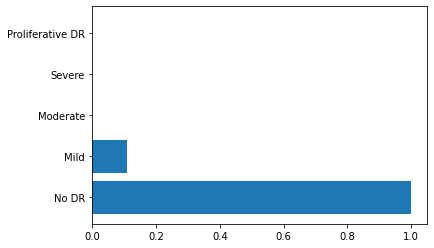

03042a663e54


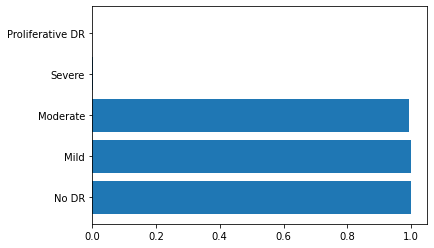

030e06ddbb04


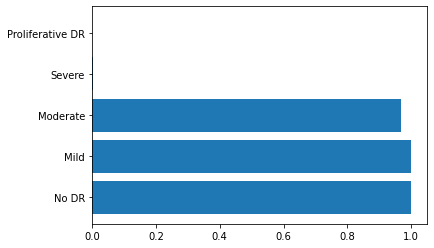

033cdbbbdfaa


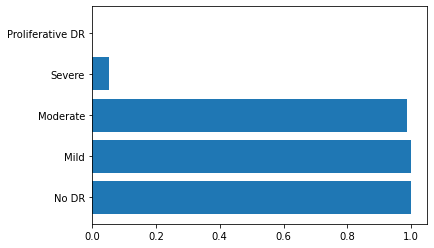

03be80919be4


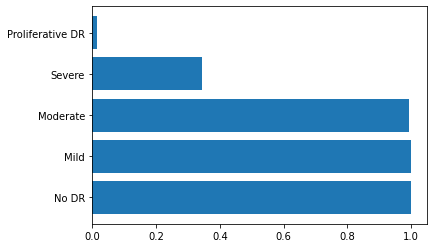

03eaa4eef484


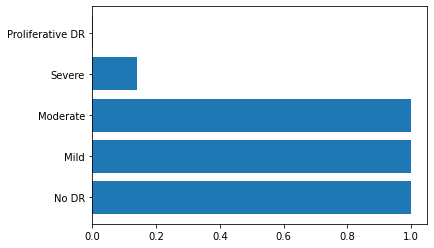

0434995d0654


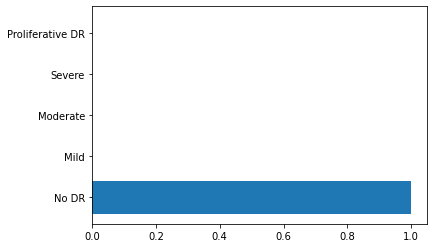

04a0773c71fb


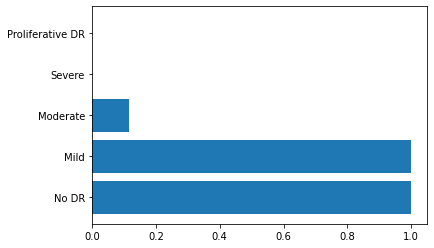

04e1b77ef107


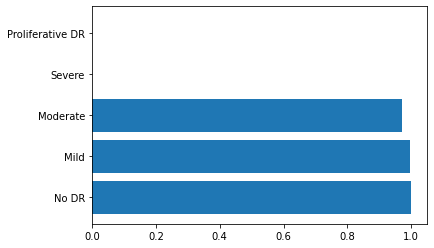

051d9d12a6ee


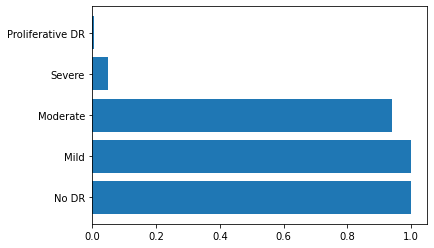

052e00f47cfa


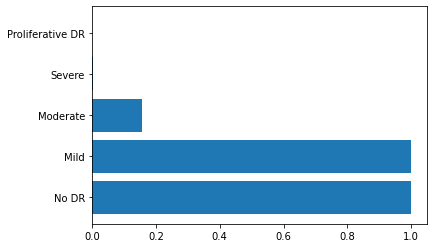

06035cfbcc18


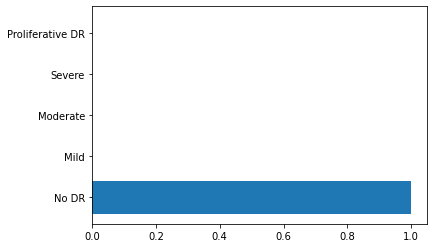

061e7dab2b76


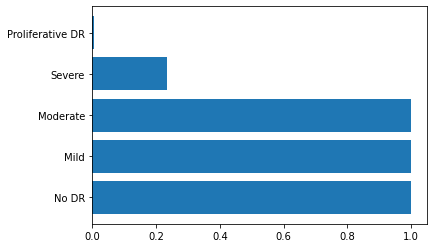

0622a0f615db


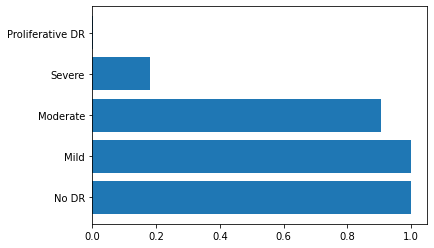

062ed40f5272


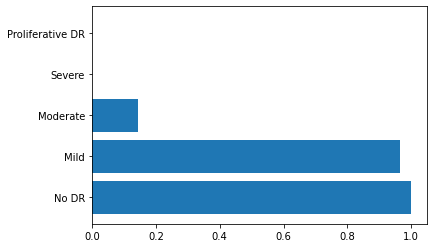

0654cdd3c01a


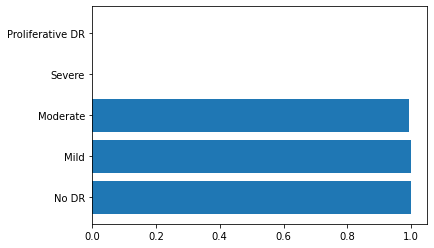

065cb18bb0b2


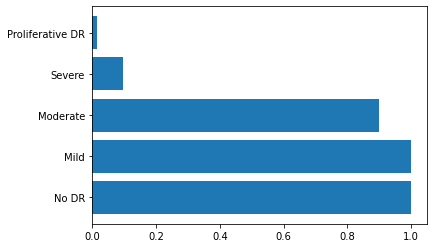

069037e82135


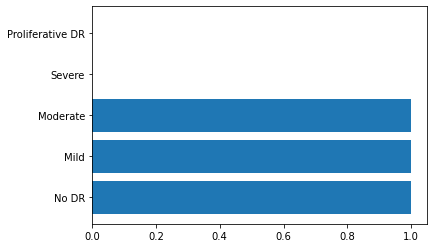

069ebdb1023d


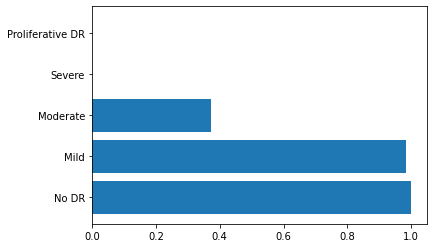

06cdd3f3f262


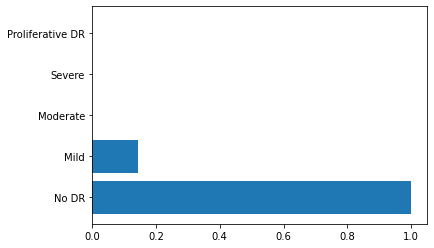

06daa7390238


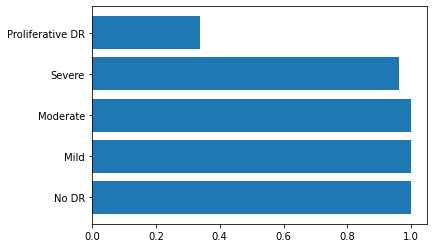

06e60df1823e


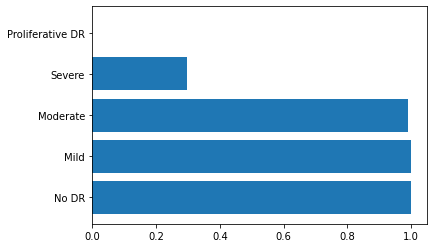

0737dfb0a164


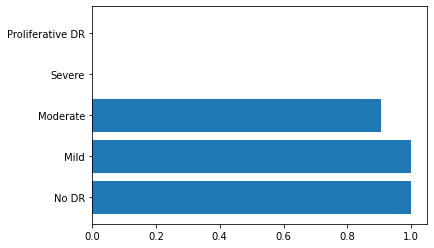

0749255f718d


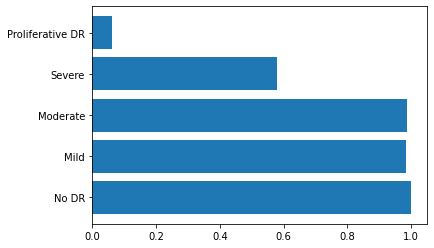

07685fac659a


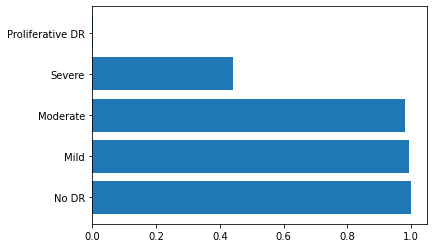

079e029f3b2e


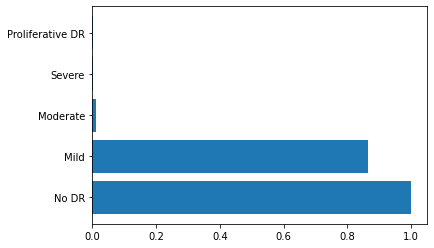

07d8d154e752


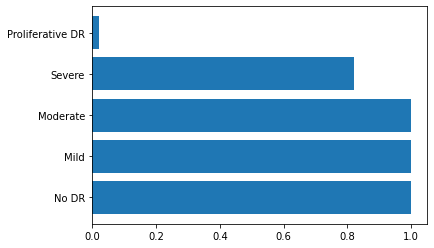

081c7ec32f27


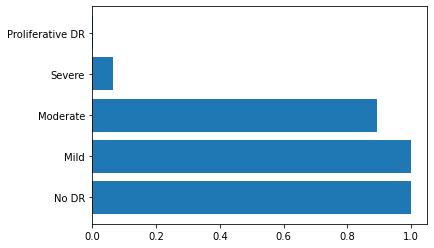

082c7ccb536a


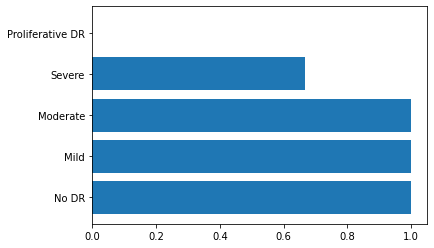

082fc6f323a1


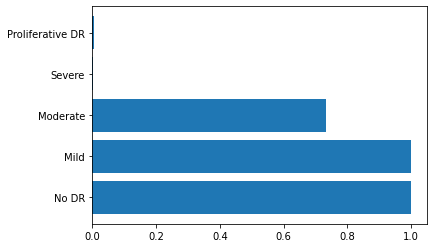

086727c22b75


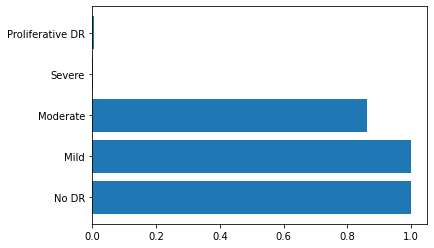

087966da55c2


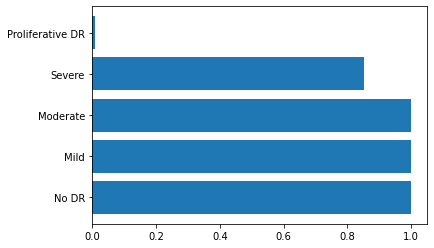

08a5afa9d62c


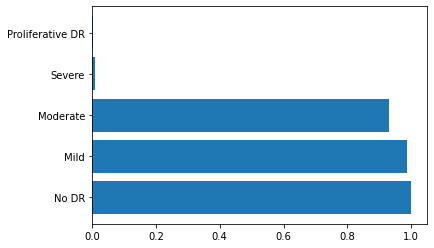

08cfae721bd8


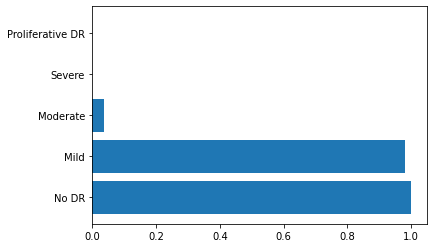

08dc27511636


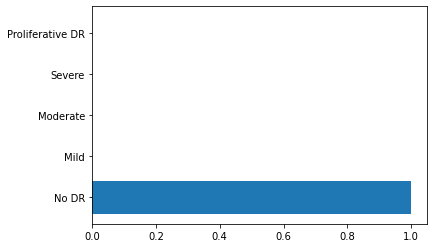

0904fcd03369


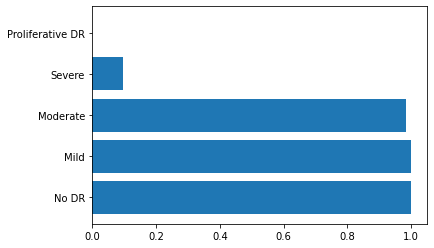

0928150bb29a


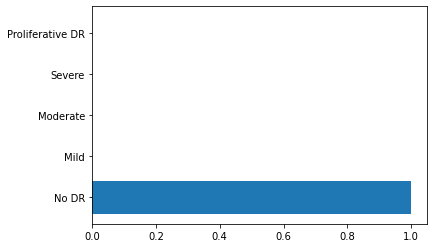

0946ae407745


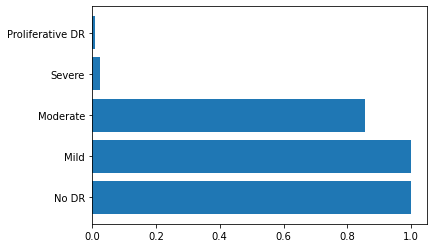

0952ca2ece1c


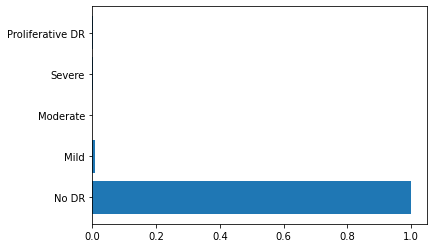

096d6bb6546b


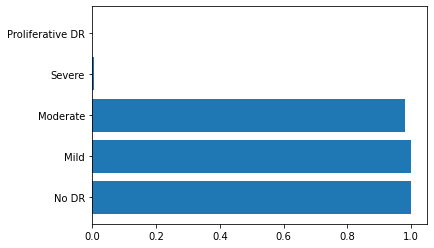

097614f1dcae


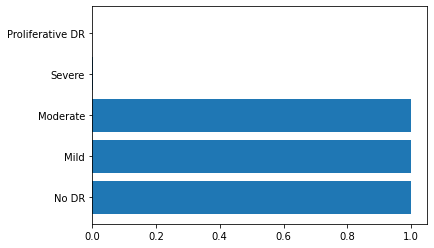

09855c888f9f


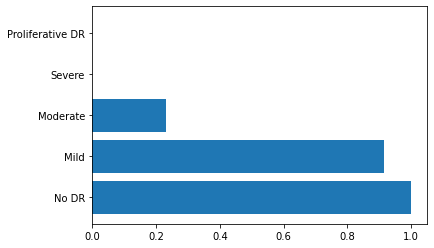

09b5e952f996


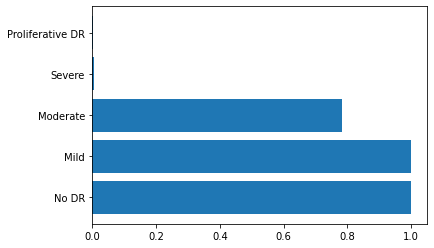

09d32c9008ca


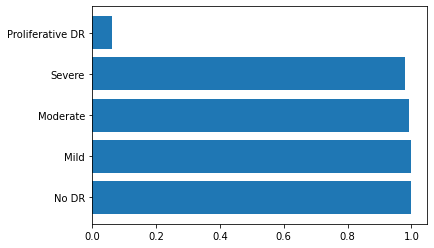

0a0780ad3395


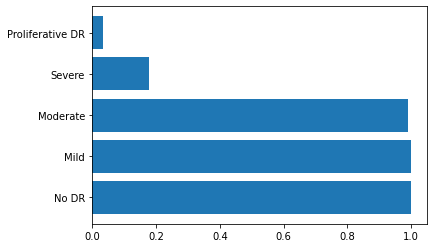

0a262e8b2a5a


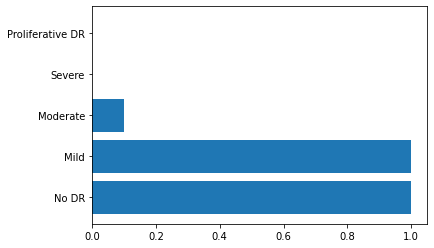

0a2b5e1a0be8


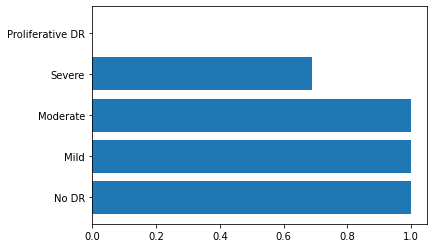

0ad36156ad5d


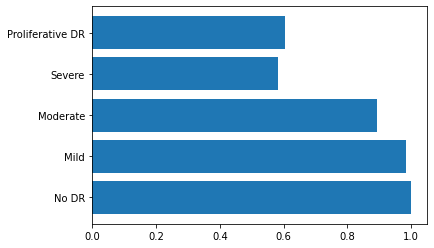

0aebb1b2aef1


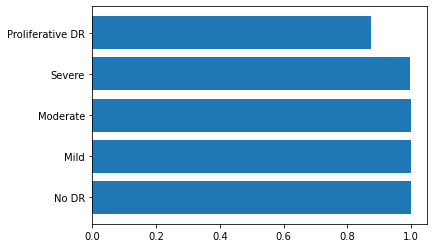

0af080866c24


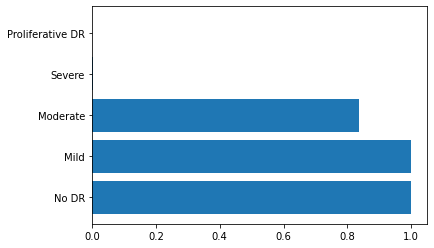

0af338c60d2d


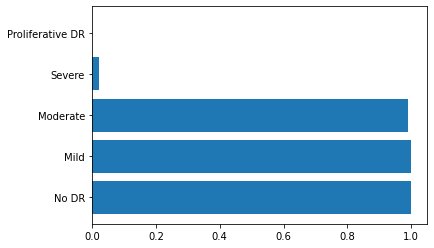

0b121d798018


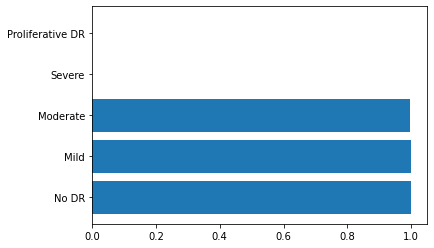

0b65c09c7bac


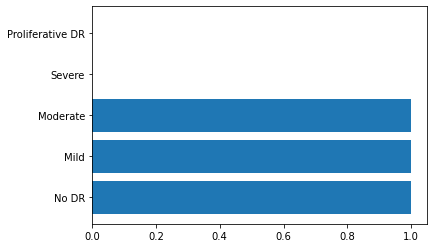

0b88274d5d7d


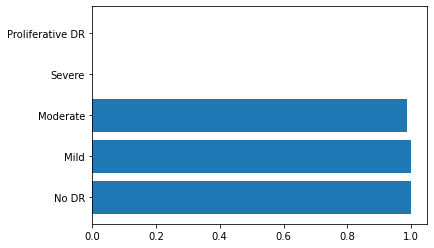

0ba16f32500e


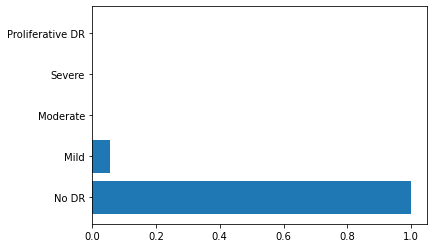

0bab4b301d71


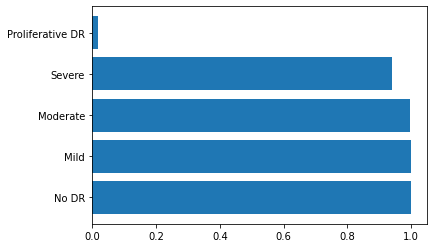

0bfa8ea173d6


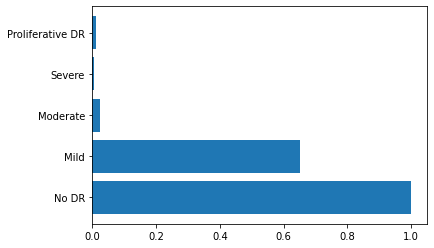

0c39fa1f2cfa


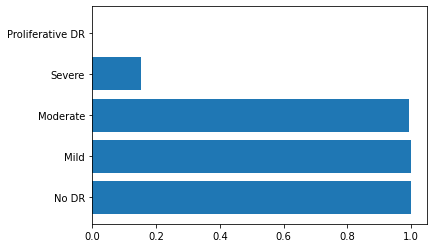

0c7e40a82c60


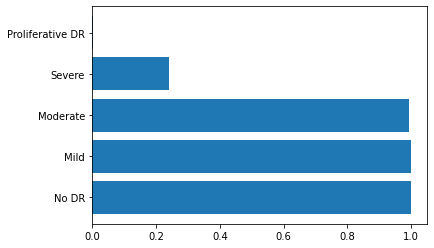

0c7e66a53ce3


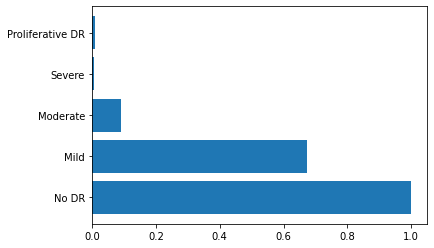

0ca261d6e31d


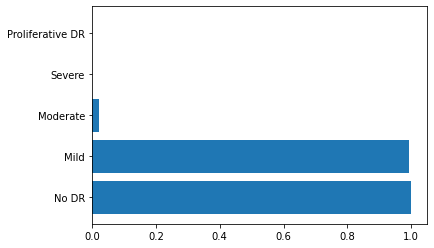

0cad3584e761


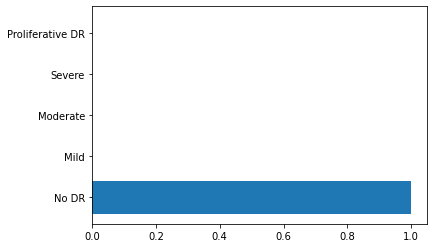

0ccfca342907


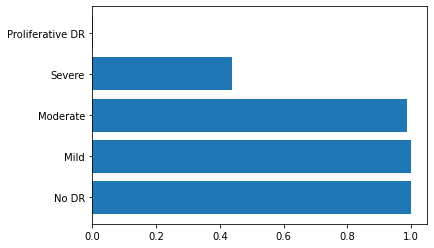

0d1610cda7fc


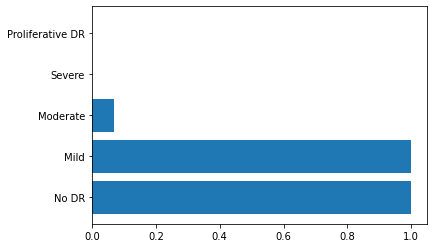

0d1c7806f918


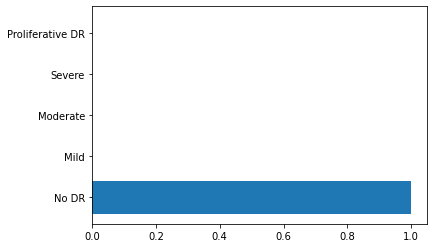

0d2c1ae24459


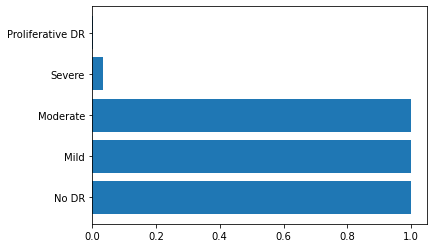

0d38fb1ec22d


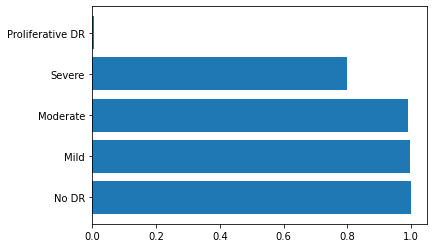

0d564d76c97c


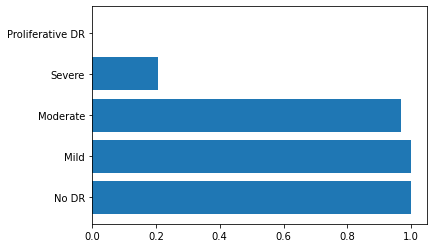

0ddb0dbbef76


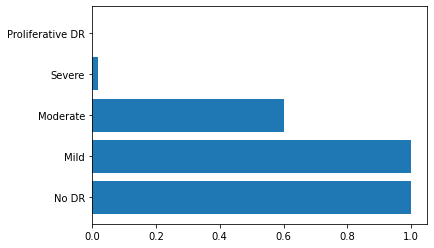

0df488d86631


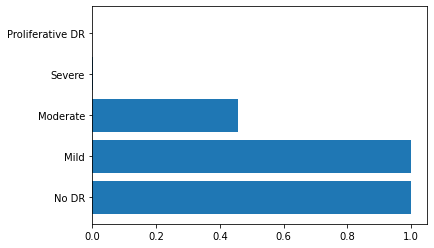

0e052b0dec40


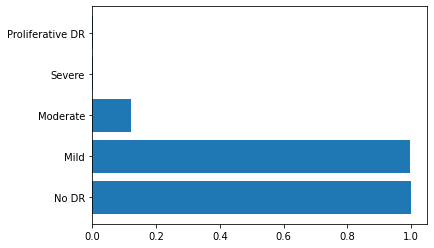

0e107399795b


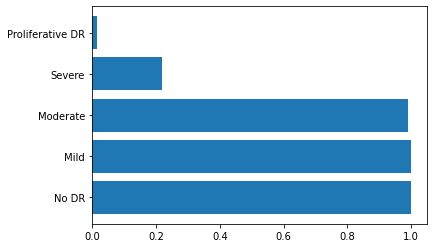

0e428b886e07


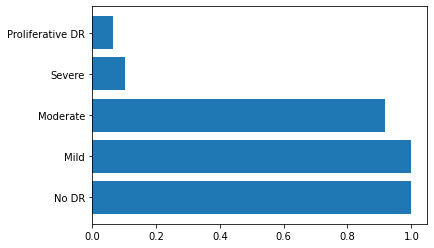

0e86fbc6cb8b


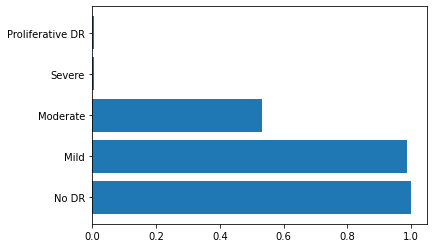

0e9d6c70eaf7


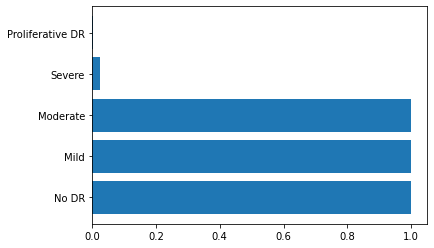

0eb6e41a8658


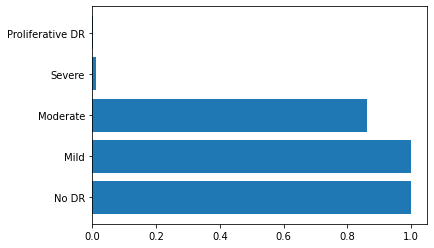

0ecaf177e85f


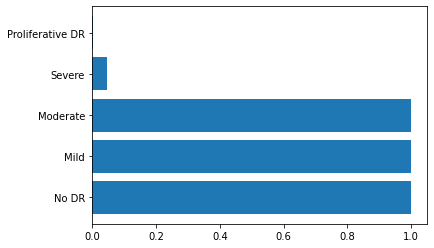

0ed192cd67a2


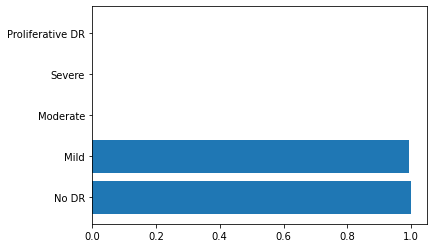

0edc0c33e929


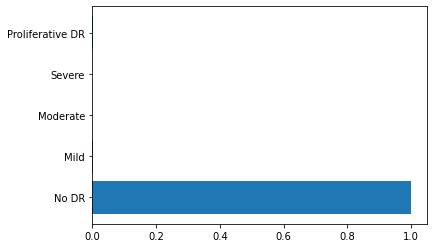

0ee72c039036


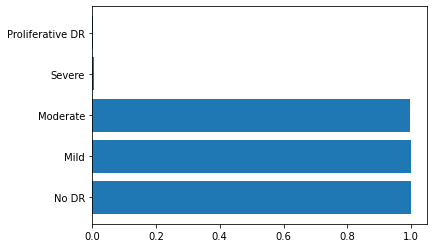

0ef1f5075178


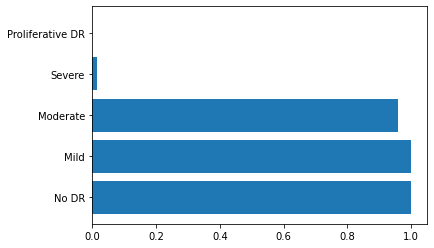

0f1613975335


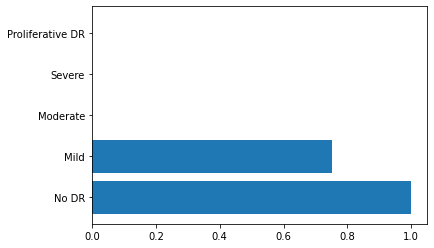

0f1a967313c3


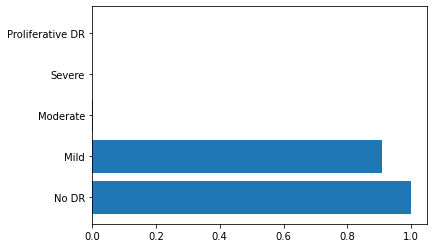

0f23c3028206


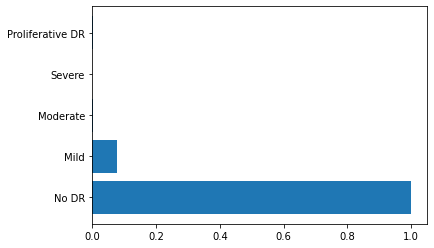

0f61878bfd0e


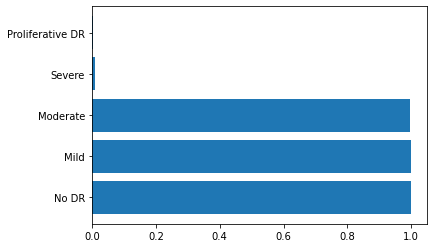

0f8fc606e17c


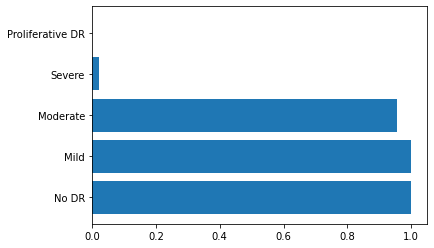

0f96e3e4a5a0


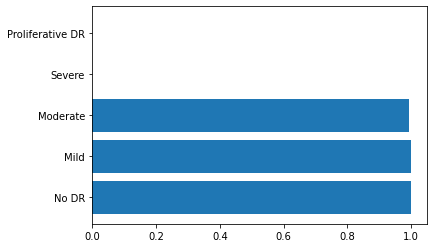

0fa8a299f431


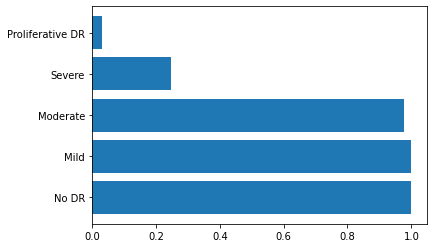

0fb31b7aef5f


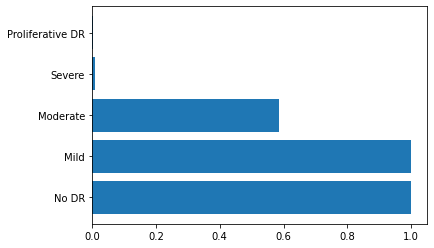

0fb78ccb86f8


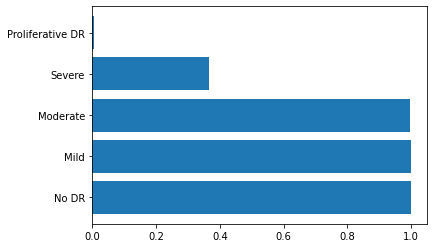

0fd68a854aa1


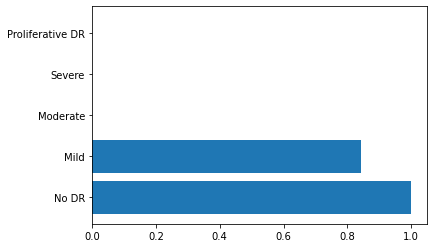

100d678b8125


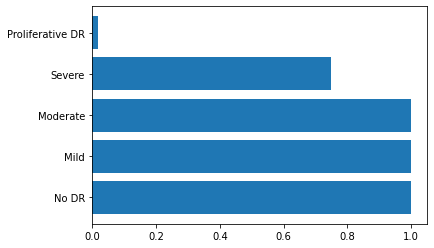

10205b883f26


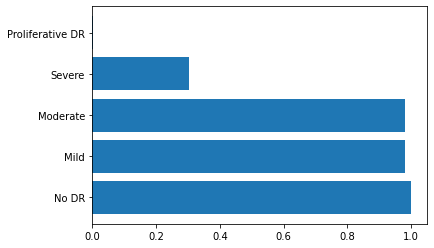

10249038e07f


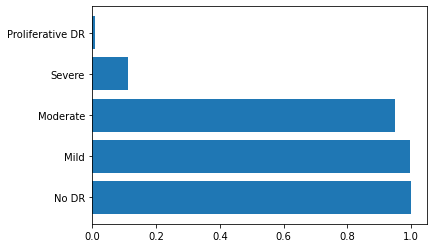

10407824638c


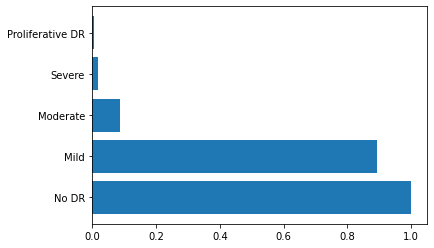

106dac320289


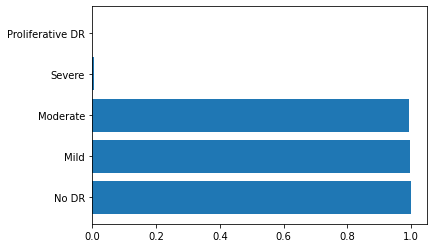

10c9d368f264


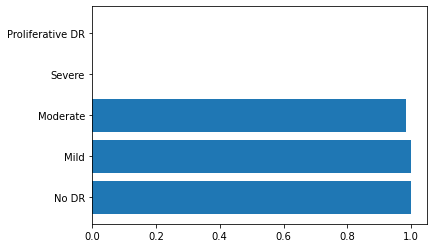

10df48fe8c6c


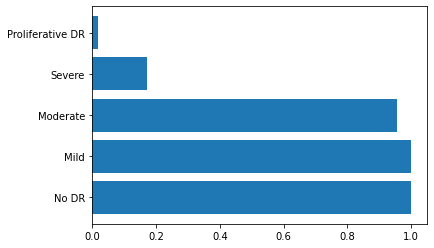

1136833be435


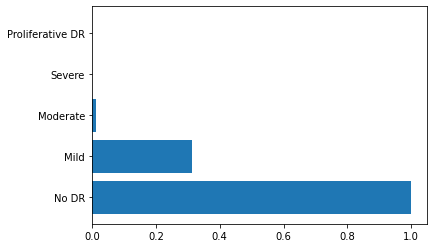

113971387d87


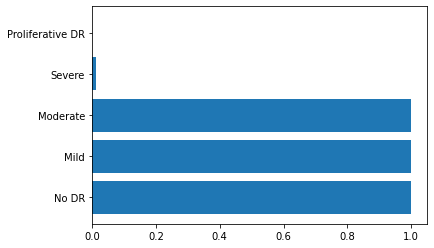

119c13369239


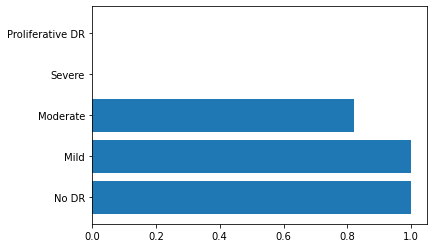

11dc8d4a66a7


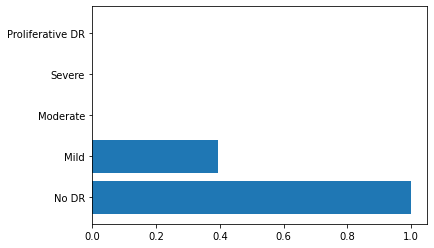

11f10a8be429


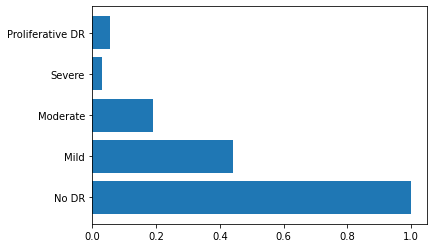

12411c037cfb


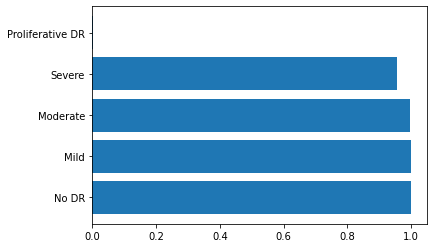

1248275c3f91


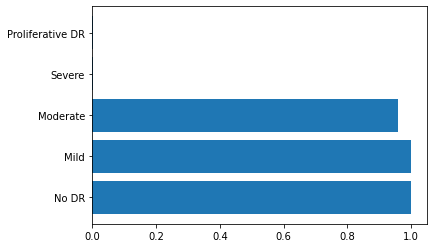

1278c303e03e


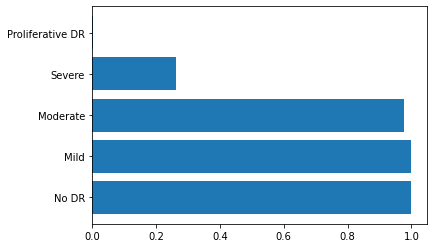

127976eab419


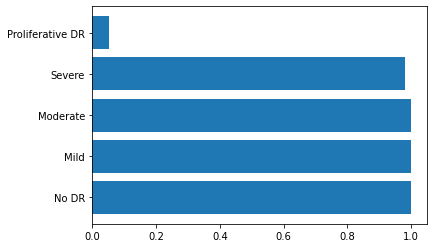

1282d33e6fbc


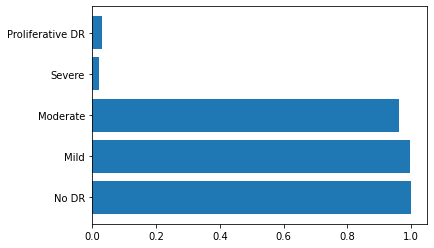

128b94971423


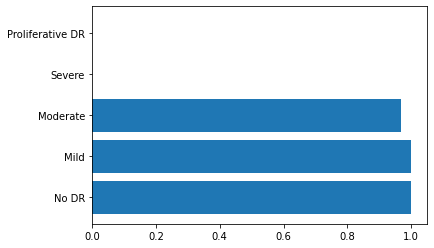

13065b0ff1e0


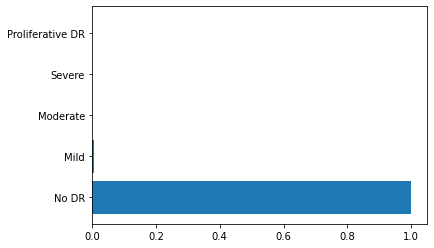

130887394f97


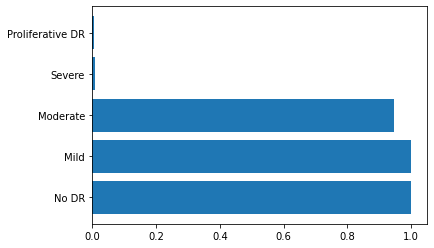

1326dad5651f


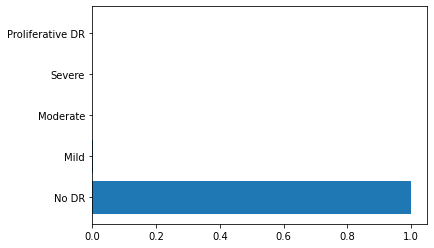

132e1876157b


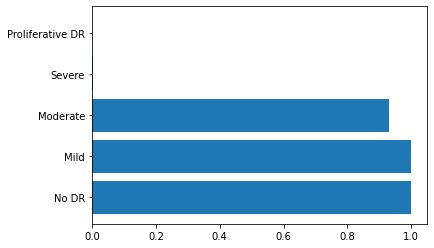

133f96f06473


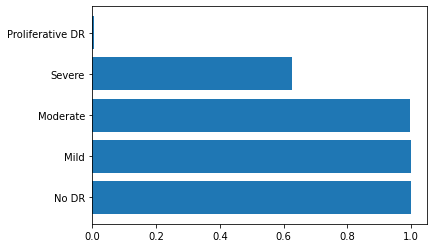

1388399910c7


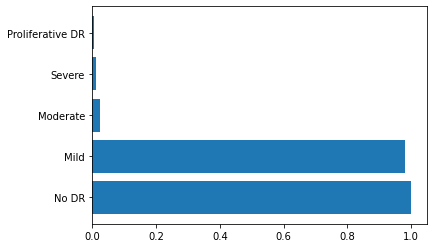

13a444b80681


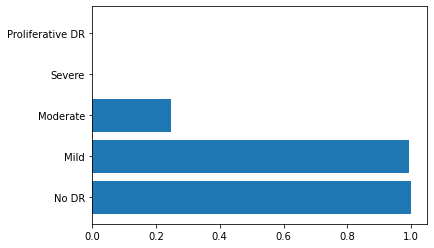

13e28ec4534a


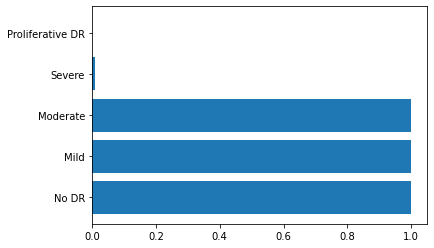

140c4f64fca3


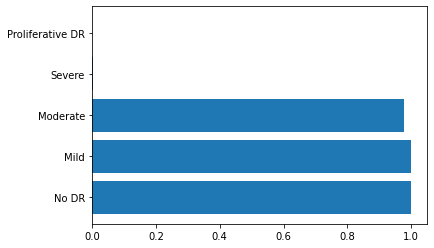

1466c7e5936e


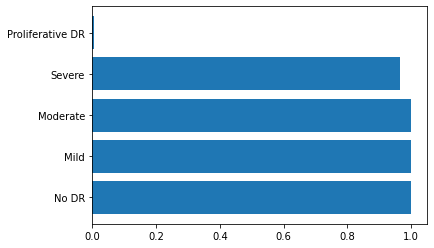

146edf3ba156


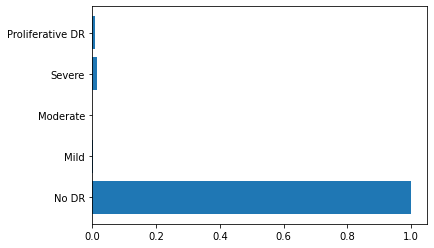

148e913a3cb7


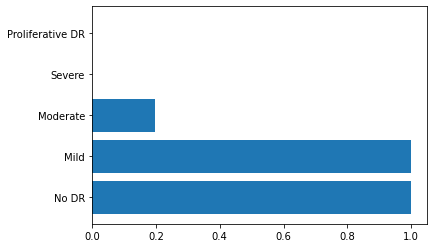

1491b52c49e4


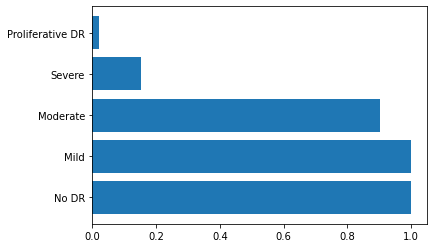

14a4f23b07a5


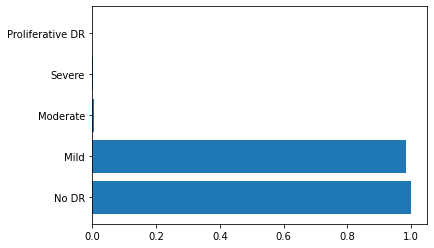

14ab77198610


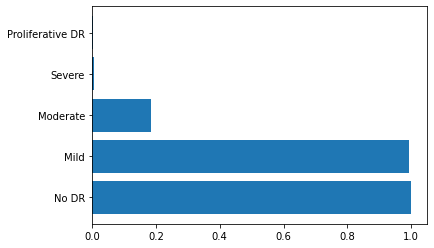

153a1a1157d8


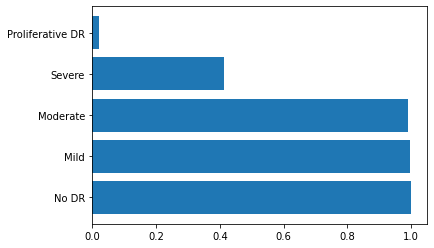

15586b5a4a6a


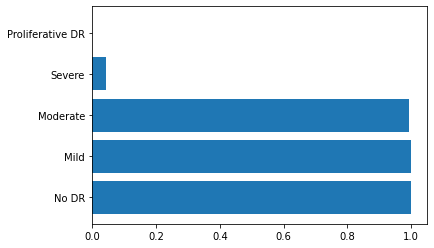

156350bc41c9


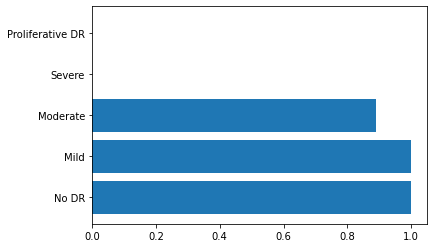

15a5df617fb1


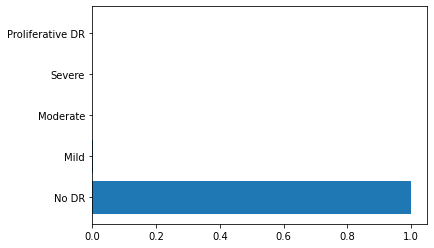

1620fa014ccb


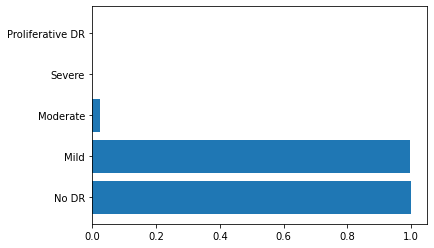

163a8bffdc88


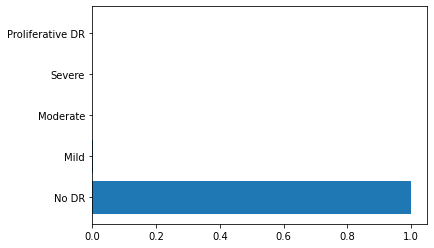

167d9edb5cc1


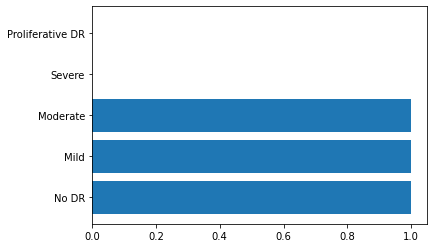

16ae04d67de3


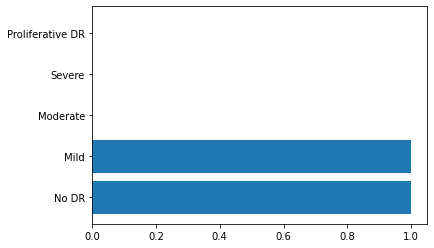

16ae52b6ac9b


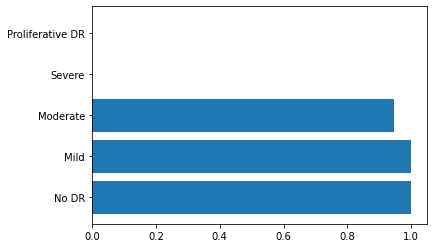

16cfea326456


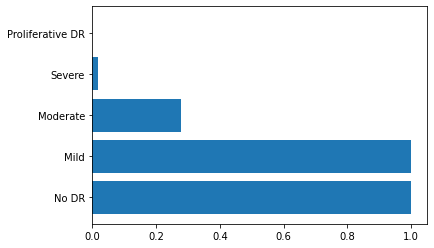

16d36c3d0553


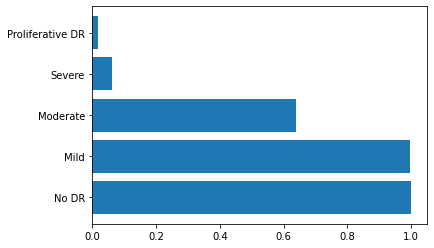

1719183e95b6


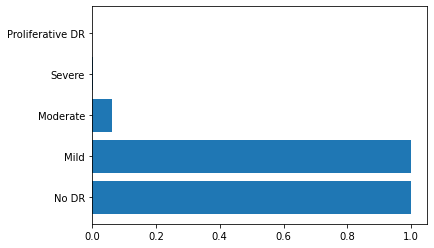

172eb75bc414


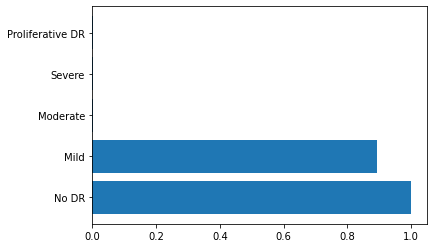

17403c0714f1


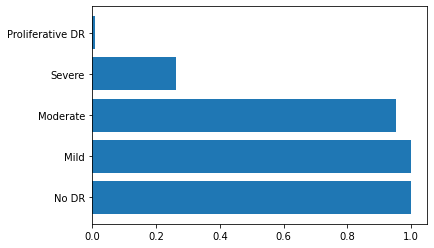

174be0d1e02d


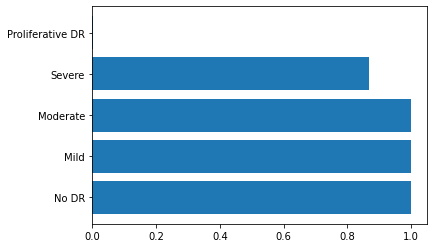

1784c33b4f27


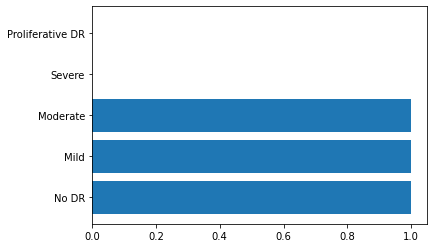

178bf0bd8902


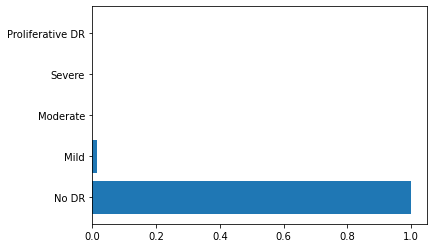

17b08e34f0ed


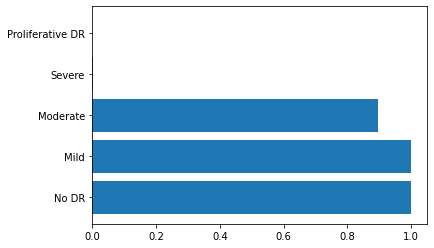

17bed9f69d84


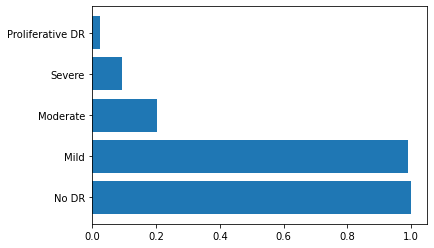

17f0a333f224


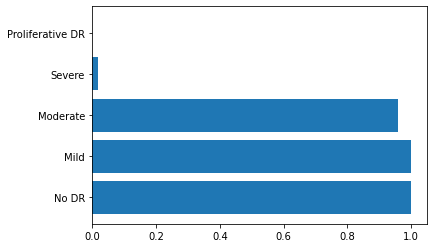

17fb965efdf3


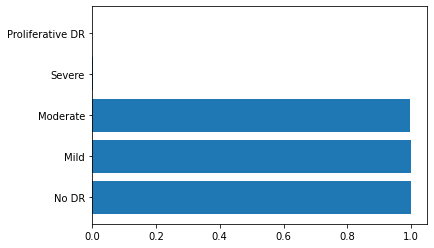

18009c3e5653


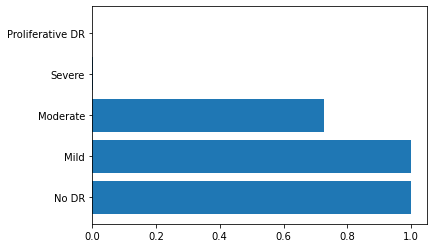

1822b6c60784


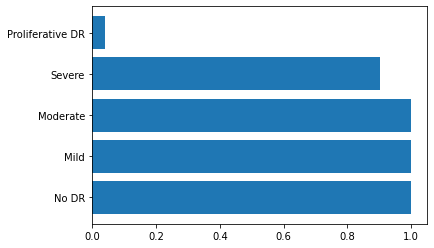

1876ac30fdc5


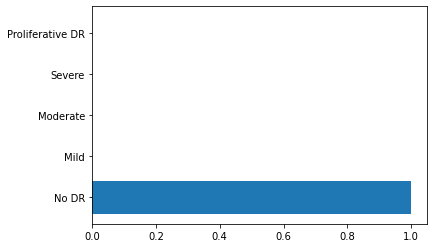

18b0e7e82204


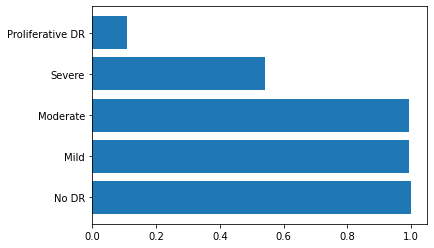

18c7998ba166


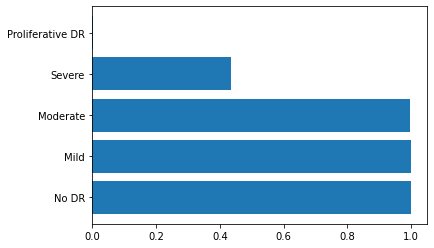

18d885cd7f0c


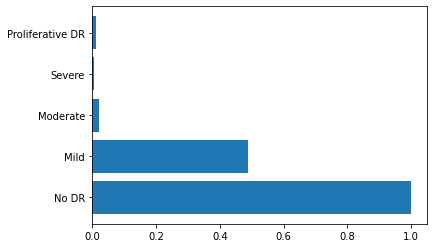

18e65ae600f3


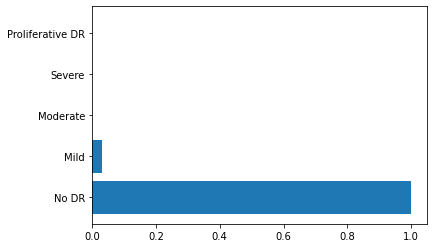

18f09deddab7


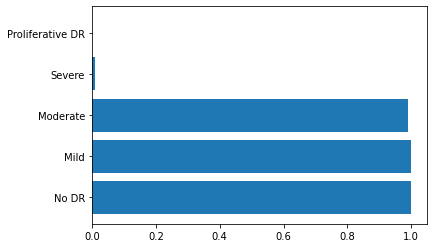

1927c7ed6570


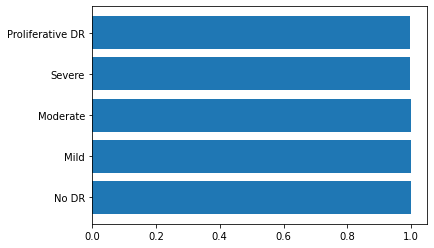

19f165a25974


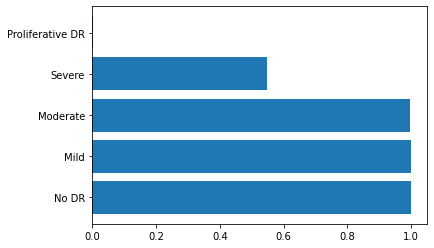

19fedfb6c8e1


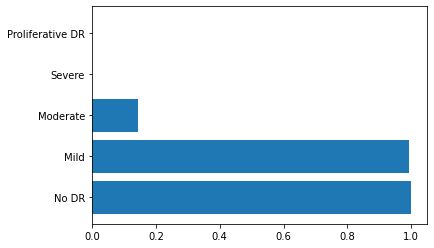

1a0a62061725


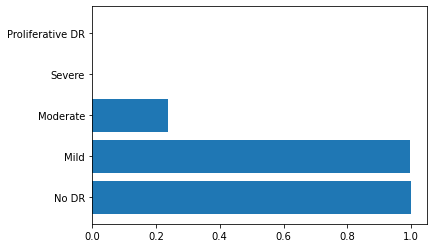

1a18d78ffb56


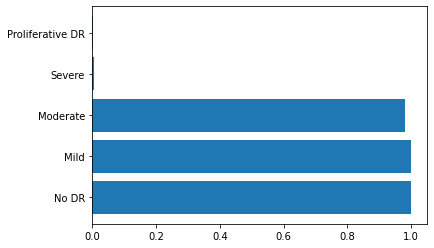

1a495e43fc7d


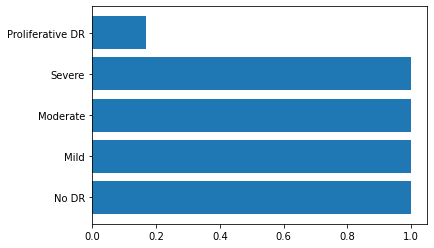

1a6b7f58d488


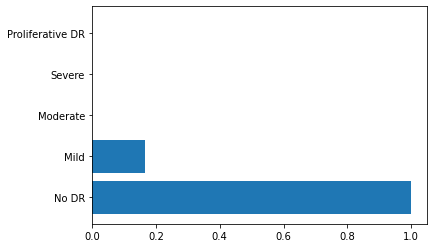

1a7fe0c18772


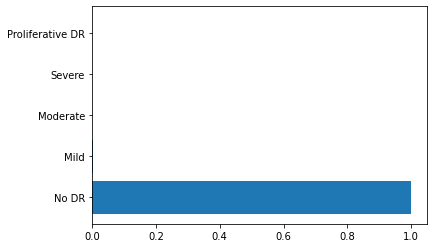

1ab40e2386ea


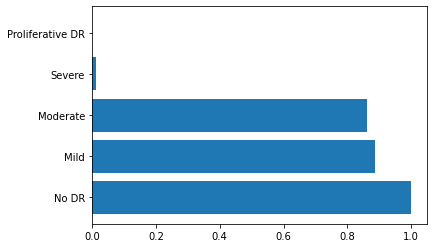

1b1522622a53


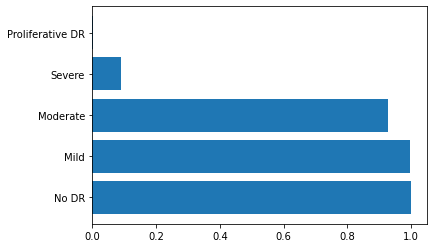

1b4843340486


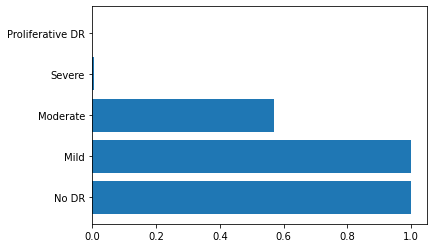

1b79278c8cb5


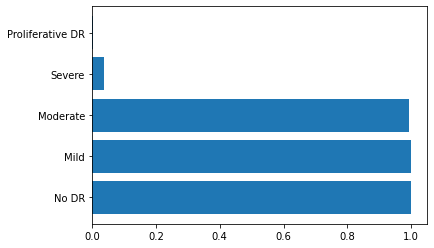

1ba29885e4ce


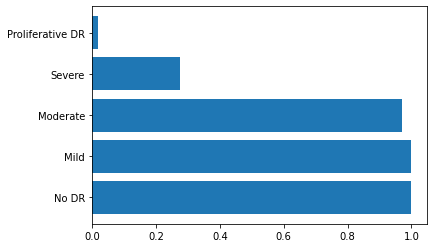

1c241074f213


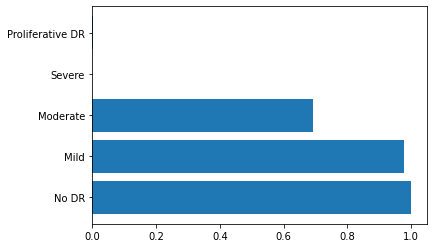

1c6139829ba9


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from tqdm import tqdm_notebook
for idx, row in tqdm_notebook(test_df.iterrows()):
    print(row['id_code'])
    plt.barh(["No DR","Mild","Moderate","Severe","Proliferative DR"], y_test_bar[idx])
    plt.show()

0    322
1    341
2    921
3    282
4     62
Name: diagnosis, dtype: int64


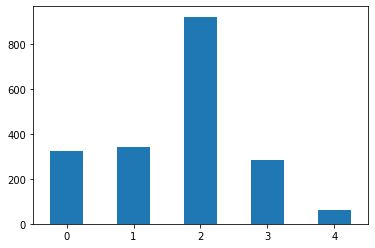

In [ ]:
print(test_df.diagnosis.value_counts().sort_index())
test_df.diagnosis.value_counts().sort_index().plot(kind="bar", rot=0)

## Prediction on test dataset with TTA (Test time Augmentation)

In [ ]:
tta_steps = 6
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(create_datagen().flow(x_test, batch_size=BATCH_SIZE, shuffle=False), steps = len(x_test)/BATCH_SIZE)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

100%|██████████| 6/6 [02:44<00:00, 27.47s/it]


In [ ]:
# TTA
y_test = preds > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('result_TTA.csv',index=False)

## Prediction evaluation (with TTA)

0     246
1     218
2    1088
3     308
4      68
Name: diagnosis, dtype: int64


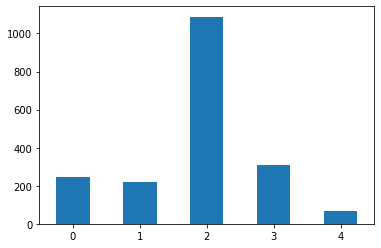

In [ ]:
# TTA
print(test_df.diagnosis.value_counts().sort_index())
test_df.diagnosis.value_counts().sort_index().plot(kind="bar", rot=0)

## Images from each predicted label

Without TTA

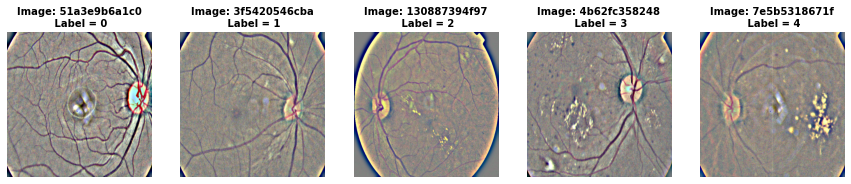

In [ ]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df[test_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"/content/test_images_ben_preprocessed_sigmaX10/{image_name}.png")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

With TTA

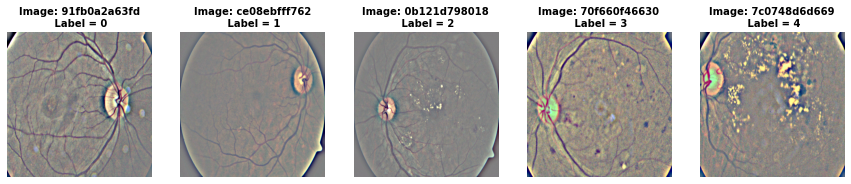

In [ ]:
# TTA
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df[test_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"/content/test_images_ben_preprocessed_sigmaX10/{image_name}.png")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);